In [1]:
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import torch, os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

In [2]:
df = pd.read_csv('fer2013.csv') 


df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
print('Total lenth of dataset: ', len(df.Usage), '\n') 
print('Total Categories we have: ', df.Usage.unique())
print('Number of data in each category: ', '{ Training: ', len(df[df.Usage == 'Training']), ' PublicTest: ', len(df[df.Usage == 'PublicTest']), ' PrivateTest: ', len(df[df.Usage == 'PrivateTest']), '}\n')
print('Total Expression Classes we have: ', df.emotion.unique(), '\n')
print('Type of the pixel data is: ', type(df.pixels[0]))

Total lenth of dataset:  35887 

Total Categories we have:  ['Training' 'PublicTest' 'PrivateTest']
Number of data in each category:  { Training:  28709  PublicTest:  3589  PrivateTest:  3589 }

Total Expression Classes we have:  [0 2 4 6 3 5 1] 

Type of the pixel data is:  <class 'str'>


In [4]:

def makemtrx(lst, n=48):
    for i in range(0, 48*48, n):  
        yield lst[i:i + n] 


In [5]:
# This function will help to show the images
def showimg(data):
    pixel = [int(i) for i in data[1].split(' ')]
    pixel = np.array(list(makemtrx(pixel)))
    plt.imshow(pixel, cmap='gray')
    plt.xlabel(f'Expression Class: {data[0]}')
    plt.plot()

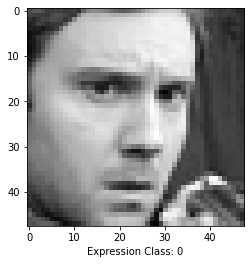

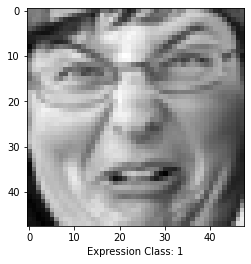

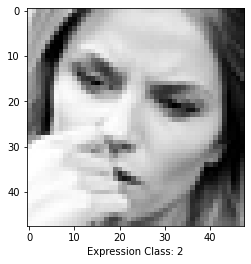

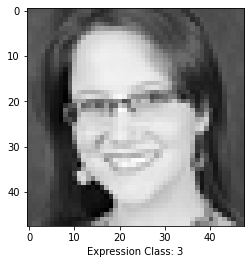

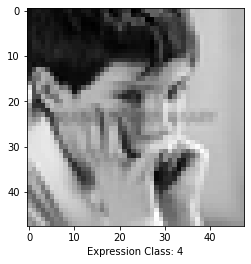

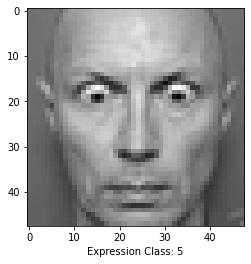

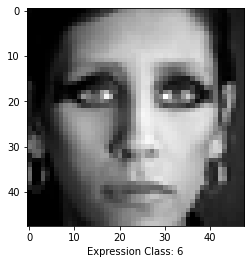

In [6]:
for i in range(7):
    plt.figure()
    showimg(df[df.emotion == i].values[0])
    
classes = {
    0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'
}


# getting the dataset ready
df_train = pd.concat([df[(df.Usage == 'Training')], df[df.Usage == 'PublicTest']], ignore_index=True).drop(['Usage'], axis=1)
df_test = df[df.Usage == 'PrivateTest'].drop(['Usage'], axis=1).reset_index().drop(['index'], 1)

# differentiating between labels and images
train_images = df_train.iloc[:, 1]
train_labels = df_train.iloc[:, 0]
test_images = df_test.iloc[:, 1]
test_labels = df_test.iloc[:, 0]


In [7]:
# this is for the transforms
train_trfm = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomCrop(48, padding=4, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5), inplace=True)
    ])
val_trfm = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])

In [8]:
class FERDataset(Dataset):
    
    def __init__(self, images, labels, transforms):
        self.X = images
        self.y = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        data = [int(m) for m in self.X[i].split(' ')]
        data = np.asarray(data).astype(np.uint8).reshape(48,48,1)
        data = self.transforms(data)
        label = self.y[i]
        return (data, label)
    
train_data = FERDataset(train_images, train_labels, train_trfm)
val_data = FERDataset(test_images, test_labels, val_trfm)

In [9]:
def showimg(data):
    img, lbl = data
    plt.figure()
    plt.imshow(torch.squeeze(img), cmap='gray')
    plt.xlabel(f'{classes[lbl]} ({lbl})')
    plt.plot()

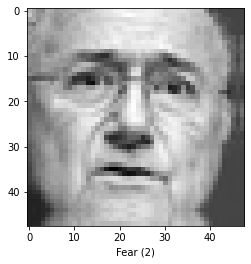

In [10]:
showimg(train_data[5])


In [11]:
random_seed = 42
torch.manual_seed(random_seed);

In [51]:
batch_num = 400

train_dl = DataLoader(train_data, batch_num, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_data, batch_num*2, num_workers=4, pin_memory=True)


In [52]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


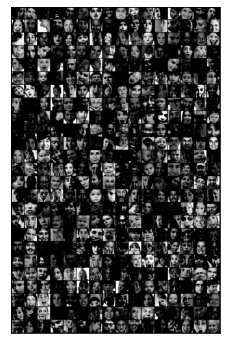

In [53]:
show_batch(train_dl)

In [16]:
def conv_block(in_chnl, out_chnl, pool=False, padding=1):
    layers = [
        nn.Conv2d(in_chnl, out_chnl, kernel_size=3, padding=padding),
        nn.BatchNorm2d(out_chnl),
        nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class FERModel(FERBase):
    def __init__(self, in_chnls, num_cls):
        super().__init__()
        
        self.conv1 = conv_block(in_chnls, 64, pool=True)           # 64x24x24 
        self.conv2 = conv_block(64, 128, pool=True)                # 128x12x12
        self.resnet1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))    # Resnet layer 1: includes 2 conv2d
        
        self.conv3 = conv_block(128, 256, pool=True)       # 256x6x6 
        self.conv4 = conv_block(256, 512, pool=True)       # 512x3x3
        self.resnet2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))    # Resnet layer 2: includes 2 conv2d
        
        self.classifier = nn.Sequential(nn.MaxPool2d(3),
                                        nn.Flatten(),
                                        nn.Linear(512, num_cls))    # num_cls
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.resnet1(out) + out
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.resnet2(out) + out
        
        return self.classifier(out)
        
model = FERModel(1, 7)
print(model)

FERModel(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (resnet1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, ep

In [17]:
for images, lbl in train_dl:
    print('shape of image: ', images.shape)
    out = model(images)
    print('shape of output: ', out.shape)
    print('Output: ', out[0])
    break

shape of image:  torch.Size([400, 1, 48, 48])
shape of output:  torch.Size([400, 7])
Output:  tensor([-2.1396, -0.4338, -3.0777, -0.6694, -0.5621,  0.4378, -2.5625],
       grad_fn=<SelectBackward>)


In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    

device = get_default_device()
print(device)

cuda


In [19]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);


In [20]:
@torch.no_grad()    
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, max_lr, model, train_loader=train_dl, val_loader=val_dl, weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []    
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
            
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [21]:
model = to_device(FERModel(1, 7), device)

In [22]:
evaluate(model, val_dl)


{'val_loss': 1.9442360401153564, 'val_acc': 0.1739473044872284}

In [23]:
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
epochs = 40

In [24]:
%%time
history = fit(epochs, max_lr, model, weight_decay=weight_decay, grad_clip=grad_clip)

Epoch [0], last_lr: 0.00006, train_loss: 1.6957, val_loss: 1.5334, val_acc: 0.4080
Epoch [1], last_lr: 0.00010, train_loss: 1.4744, val_loss: 1.5108, val_acc: 0.4152
Epoch [2], last_lr: 0.00018, train_loss: 1.3728, val_loss: 1.3119, val_acc: 0.5058
Epoch [3], last_lr: 0.00028, train_loss: 1.2823, val_loss: 1.2977, val_acc: 0.5157
Epoch [4], last_lr: 0.00039, train_loss: 1.2285, val_loss: 1.3199, val_acc: 0.5062
Epoch [5], last_lr: 0.00052, train_loss: 1.1741, val_loss: 1.2403, val_acc: 0.5278
Epoch [6], last_lr: 0.00064, train_loss: 1.1261, val_loss: 1.1941, val_acc: 0.5693
Epoch [7], last_lr: 0.00076, train_loss: 1.1047, val_loss: 1.1093, val_acc: 0.5854
Epoch [8], last_lr: 0.00086, train_loss: 1.0603, val_loss: 1.1176, val_acc: 0.5959
Epoch [9], last_lr: 0.00094, train_loss: 1.0282, val_loss: 1.1063, val_acc: 0.5834
Epoch [10], last_lr: 0.00098, train_loss: 1.0109, val_loss: 1.2128, val_acc: 0.5409
Epoch [11], last_lr: 0.00100, train_loss: 0.9781, val_loss: 1.0646, val_acc: 0.6019
Ep

In [25]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    

In [26]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [43]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epochs')
    plt.ylabel('accuracies')
    plt.title('Accuracy vs No. of Epochs')

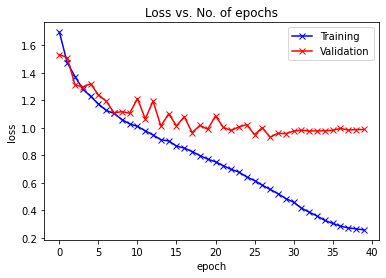

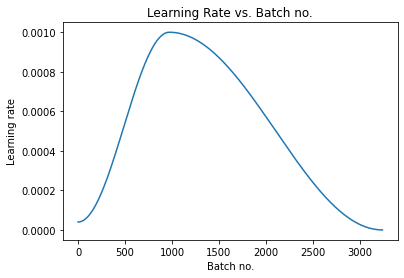

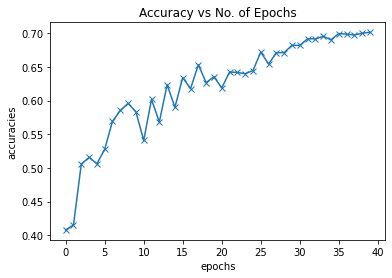

In [45]:
plot_losses(history)
plt.figure()
plot_lrs(history)
plt.figure()
plot_accuracies(history)


In [28]:
torch.save(model.state_dict(), 'FER2013-Resnet9.pth')


In [31]:
def output_label(label):
    output_mapping = {
                 0: "0",
                 1: "1",
                 2: "2",
                 3: "3",
                 4: "4", 
                 5: "5", 
                 6: "6",
                 7: "7",
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = []
y_true = []

for inputs, labels in val_dl:
        output = model(inputs) 
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 

# constant for classes
names = ('Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral')
classes = tuple([str(x) for x in range(7)])
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("Classification report for FNN :\n%s\n"
      % (classification_report(y_true, y_pred)))

Classification report for FNN :
              precision    recall  f1-score   support

           0       0.63      0.64      0.63       491
           1       0.80      0.73      0.76        55
           2       0.60      0.55      0.57       528
           3       0.89      0.88      0.88       879
           4       0.53      0.56      0.55       594
           5       0.83      0.82      0.82       416
           6       0.67      0.68      0.67       626

    accuracy                           0.70      3589
   macro avg       0.71      0.70      0.70      3589
weighted avg       0.70      0.70      0.70      3589




In [42]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
import numpy as np

y_pred = []
y_true = []

for inputs, labels in val_dl:
        output = model(inputs) 
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 

# constant for classes
classes = tuple([str(x) for x in range(7)])
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print("Classification report for FNN :\n%s\n"
      % (classification_report(y_true, y_pred)))

# Graphical analytics
names = ('Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral')
# plt.figure(figsize=(7,7))
# plot_confusion_matrix(cf_matrix, y_true)

Classification report for FNN :
              precision    recall  f1-score   support

           0       0.63      0.64      0.63       491
           1       0.80      0.73      0.76        55
           2       0.60      0.55      0.57       528
           3       0.89      0.88      0.88       879
           4       0.53      0.56      0.55       594
           5       0.83      0.82      0.82       416
           6       0.67      0.68      0.67       626

    accuracy                           0.70      3589
   macro avg       0.71      0.70      0.70      3589
weighted avg       0.70      0.70      0.70      3589


